For Theory the following videos are useful: 
1) https://www.youtube.com/watch?v=jzJactQXFDk
2) https://www.youtube.com/watch?v=uI19wIdzh9M
3) https://www.youtube.com/watch?v=RsX01aYbQdI
4) https://www.youtube.com/watch?v=ScWTYHQra5E

In the previous week we built a multi-layer perceptron network that we trained to generate names with "names.txt" dataset. Before moving on to more complex models such as RNN-s, LTSM-s and architectures that use transformers, let's focus a little on improving the previous model. 


In this week we will be applying Batch normalization as discussed in the following paper: https://arxiv.org/abs/1502.03167


1) we will Fix initialization values and subsequently the terrible starting loss
2) we will Fix tanh saturation problem that causes a lot of neurons to "die"  
3) we will touch upon kaimin initialization and how we came up with numbers we use for normalizations. 
4) then we move on to Batch normalization
5) A bit of clean up, in order to make the code more respectable and "pytorch"-esque 
6) Some visualizations on what we have done

##### Last Weeks model

In [31]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import random


In [36]:
# import the dataset
words = open("./names.txt", "r").read().splitlines()
# Create stoi and itos mappings for tensor indexations. 
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)



In [37]:
# Showing splitting the dataset into training, development and testing sets

block_size = 3
def build_dataset(words):  

  X, Y = [], []
  
  for w in words:

    context = [0] * block_size
    for ch in w + '.':

      ix = stoi[ch]

      X.append(context)
      Y.append(ix)

      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [39]:
#constructing the neural network 

n_embd = 10 
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),generator=g)
b1 = torch.randn(n_hidden,generator=g)
W2 = torch.randn((n_hidden, vocab_size),generator=g) 
b2 = torch.randn(vocab_size,generator=g) 


parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True
  
print(C.shape)
print(W1.shape)
print(b1.shape)
print(W2.shape)
print(b2.shape)

11897
torch.Size([27, 10])
torch.Size([30, 200])
torch.Size([200])
torch.Size([200, 27])
torch.Size([27])


In order to reiterate what is going on: 

we have, block size = 3, vocabulary size = 27 (letters + '.'), size of each embedding vector = 10, hidden neurons = 200. 

<div style="text-align: center; background-color: white;">
    <img src="Neural Network.png" alt="Description of the image" />
</div>

In [35]:
# training the first epoch

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)

    # batch 
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # embed characters into vector space
    embcat = emb.view((emb.shape[0], -1)) # flatten
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer activation
    logits = h @ W2 + b2 # output layer 
    print("logits: ")
    print(logits)
    loss = F.cross_entropy(logits, Yb) # cross-entropy loss

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f"{i} / {max_steps}: {loss.item()}")

    lossi.append(loss.item())
    break

logits: 
tensor([[-2.3527e+00,  3.6437e+01, -1.0731e+01,  5.7165e+00,  1.8641e+01,
         -1.1700e+01, -2.1991e+00,  1.8535e+00,  1.1000e+01,  1.0673e+01,
          1.2351e+01, -1.0381e+01,  4.7243e+00, -2.4426e+01, -8.5909e+00,
          1.9024e+00, -1.2274e+01, -1.2475e+01, -2.3278e+01, -2.0163e+00,
          2.5877e+01,  1.4211e+01,  1.7769e+01, -1.0920e+01, -2.0733e+01,
          6.4560e+00,  1.1161e+01],
        [ 1.4406e+01,  4.5717e+00, -5.3498e+00,  1.7692e+01,  1.3044e+01,
         -4.3253e+00, -9.8614e+00,  1.2019e+01,  2.3452e+01,  4.5601e+00,
          8.0418e+00, -1.4403e+01,  3.2477e+00,  1.2516e+00, -1.5957e+01,
          2.1400e+01, -1.1977e+01, -6.8559e+00,  1.9288e+01,  6.1448e+00,
          1.4560e+01, -2.9201e+00,  2.8636e+00,  3.6767e+00,  2.3757e+01,
         -1.3822e+01,  1.8178e+01],
        [-5.7424e+00,  1.3406e+01,  1.5527e+01,  1.5761e+01,  2.0455e+01,
          2.9779e+00,  8.9216e+00,  1.9749e+01,  9.3163e+00,  2.5602e+01,
          2.0755e+01,  4.4928e+

##### Issue arises

The initialization parameters are much worse than loss obtained by assigning equal probability to every character. Since in that case every character would have a chance of 1/27 to come up, which means: 

loss = -log(1/27) = 3.29

Looking at loss on dev and test, they are not much better. This is because there is large discreptancy between initialized weights and biases. The big issue is that our initial loss is much worse than what we would get from randomly choosing characters, this is because the model is "Very confidently" wrong. 


In [6]:

@torch.no_grad()
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "dev": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]

    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view((emb.shape[0], -1)) # (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 # (N, n_hidden)
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)

    print(f"{split} loss: {loss.item()}")

split_loss("train")
split_loss("dev")

train loss: 25.167741775512695
dev loss: 25.140993118286133


In [7]:
# sampling from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # Forward pass
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)

        ix = torch.multinomial(probs, num_samples = 1).item()

        # Shift the Context Window
        context = context[1:] + [ix]

        if ix == 0:
            break

        out.append(ix)
    
    print("".join(itos[i] for i in out))
    
    # Basically, initial weights are awful. 


rrnhodydiedigdyxzvkhhjkdoewiddxshvyyhjkyixfkcoyhshojyhguyozvwucovwixtyxfvwthslrhcgfy
rrnhovwthslrhcgfccamhjkdokhdnejkyojyhguyozvwucovwthsewgmtiofvyrhgtfxjkcynsrqhs
rrnhvqbgcdyhdyrzucoyhshvyyhguyozvwucovwidtesjrhguyozvwucovwixtyxfvwthslrhcvyhcyysewylsouhozwidtesjrhguyozvyyhjkyixfkkrnuzbthrfwtksjnhguyozvwthslkdaadzetagddrewaesyxshvyyhodydiddxshvyyhjkdixjyrnnxvymhjzigdyxzvkhhjkdgxheoyhshodydiejoyhshojyhguyozvwuhjryhcyysoadiddxshvyycoes
rrnhodydiediddadiddxshvyyhjkdokhdnejkhgkbdnrzkhojyhguyozvwuhjryhcyysewgmtiofvyrhguyozvyyhjkdixjyhguyozvyyhdyrzucovwthsjkhgkbdnrzoahxjy


hvcyhguyozvyyhjkigkyojvwhvzkhjciyfvyrhguyozvyyhddrzvwthslrhxvymhjzigkyojyhguyozvwucovwthslkdaadzdyxzvkhhjkdixjyrnuojrhguyozvwucovwthslkdjxvccvnvshxjyrhguyozvyyhjkdoewidtesjrhguyozvwucovwths






rrnhvqbgxdyoadiddadiddxshvyyhddrewaejy

hvcyhguyozvwucovwixtyxfvwovsmcjkhgkbdnrzkhojyhguyozvwths


rrnhvqbgxdyrzucovwiekkoovwthslkdaadjdyhdyrzgthxjyrnnxvymhjkdoewidtesjrhguyozvwucovwthslkdaadzdyxzvkhhjkyixfkcovwthsewgmtiofvyrhguy

##### fixing the intialized weights 

we can initalize weights and biases on the output layer with smaller numbers in order to have smaller magnitude discreptancy between the parameters.

In [8]:
n_embd = 10 
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),generator=g)
b1 = torch.randn(n_hidden,generator=g)
W2 = torch.randn((n_hidden, vocab_size),generator=g) * 0.01 # Initialize to small values
b2 = torch.randn(vocab_size,generator=g) * 0 # Remove bias


parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

11897


In [9]:
ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)

# batch 
Xb, Yb = Xtr[ix], Ytr[ix]

# forward pass
emb = C[Xb] # embed characters into vector space
embcat = emb.view((emb.shape[0], -1)) # flatten
hpreact = embcat @ W1 + b1 # hidden layer pre-activation
h = torch.tanh(hpreact) # hidden layer activation
logits = h @ W2 + b2 # output layer 
loss = F.cross_entropy(logits, Yb) # cross-entropy loss

print(f"initial loss = {loss}")

initial loss = 3.322058916091919


##### Fixing Tanh saturation 

Now that we have fixed the problem with initialization, the next issue we will tackle is dying neurons due to saturation of the tanh function. 

* If tanh outputs value close to -1 or 1, it's derivative becomes close to zero
    * reminder, derivative of tanh(x) = 1 - tanh(x)^2
* derivative being close to 0 leads to vanishing gradients and subsquently inactive or "dead" neurons that no longer contribute to learning. 
    * we can fix this by initializing W1 and b1 with lower numbers. That is because W1 and b1 are the input parameters with which the embedding matrix C is multiplied by.
    * this works because we want to normalize the pre-activation values to smaller values in order to avoid tanh saturation

Text(0.5, 1.0, 'tanh')

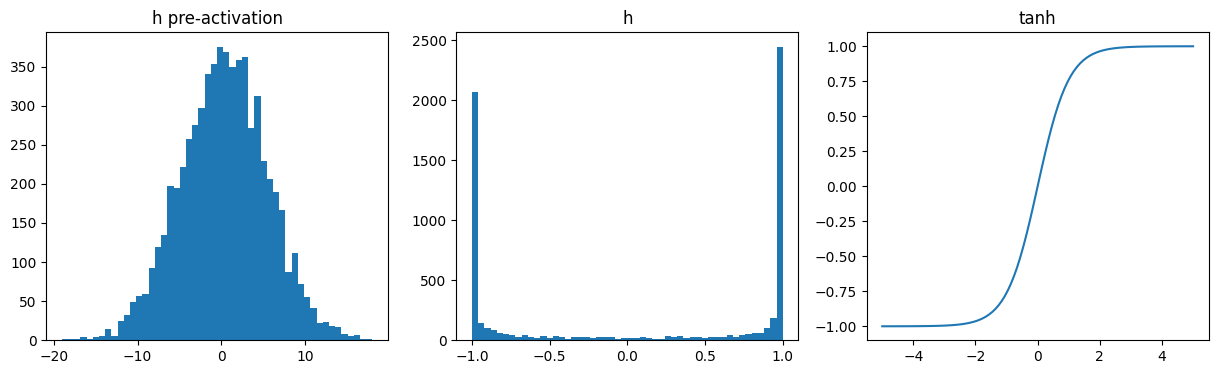

In [10]:
fig, axes = plt.subplots(1, 3, figsize = (15, 4))


axes[0].hist(hpreact.flatten().data, bins = 50);
axes[0].set_title("h pre-activation")

axes[1].hist(h.flatten().data, bins = 50);
axes[1].set_title("h")

axes[2].plot(torch.linspace(-5, 5, 100), torch.tanh(torch.linspace(-5, 5, 100)));
axes[2].set_title("tanh")

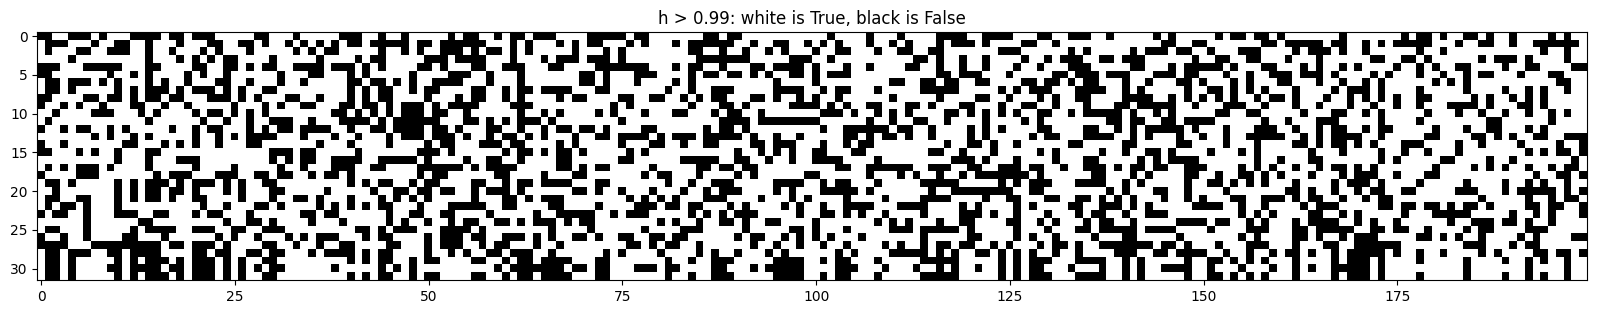

In [11]:
plt.figure(figsize = (20, 10))
plt.imshow(h.abs() > 0.99, cmap = "gray", interpolation='nearest')
plt.title("h > 0.99: white is True, black is False");

# the white blocks are dead neurons, if an entire column ever becomes white the neural network is done as an entire layer would be dead and thus never learning. 

let's fix it

In [12]:
# let's also multiply W1 and b1 by some small values

n_embd = 10 
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),generator=g) * 0.2
b1 = torch.randn(n_hidden,generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),generator=g) * 0.01 # Initialize to small values
b2 = torch.randn(vocab_size,generator=g) * 0 # Remove bias


parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

11897


In [13]:
ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)

# batch 
Xb, Yb = Xtr[ix], Ytr[ix]

# forward pass
emb = C[Xb] # embed characters into vector space
embcat = emb.view((emb.shape[0], -1)) # flatten
hpreact = embcat @ W1 + b1 # hidden layer pre-activation
h = torch.tanh(hpreact) # hidden layer activation
logits = h @ W2 + b2 # output layer 
loss = F.cross_entropy(logits, Yb) # cross-entropy loss

print(f"initial loss = {loss}")

initial loss = 3.3134593963623047


Text(0.5, 1.0, 'tanh')

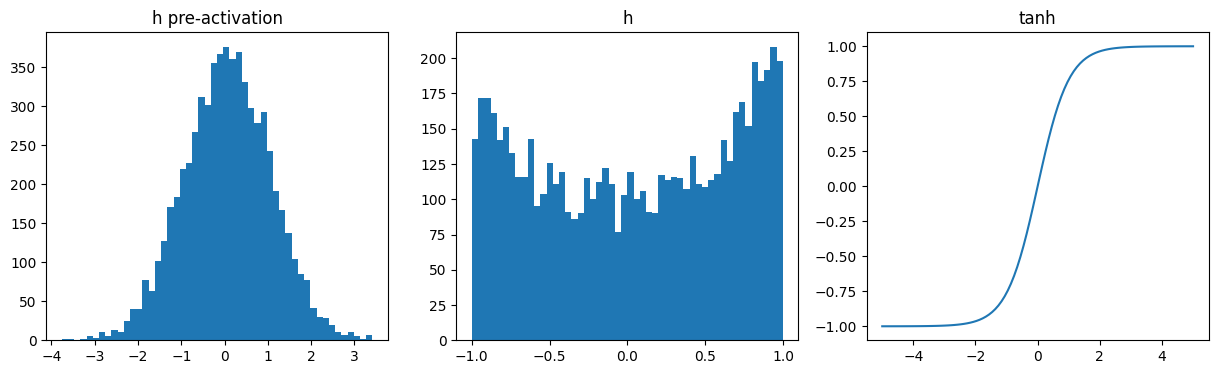

In [14]:
fig, axes = plt.subplots(1, 3, figsize = (15, 4))


axes[0].hist(hpreact.flatten().data, bins = 50);
axes[0].set_title("h pre-activation")

axes[1].hist(h.flatten().data, bins = 50);
axes[1].set_title("h")

axes[2].plot(torch.linspace(-5, 5, 100), torch.tanh(torch.linspace(-5, 5, 100)));
axes[2].set_title("tanh")

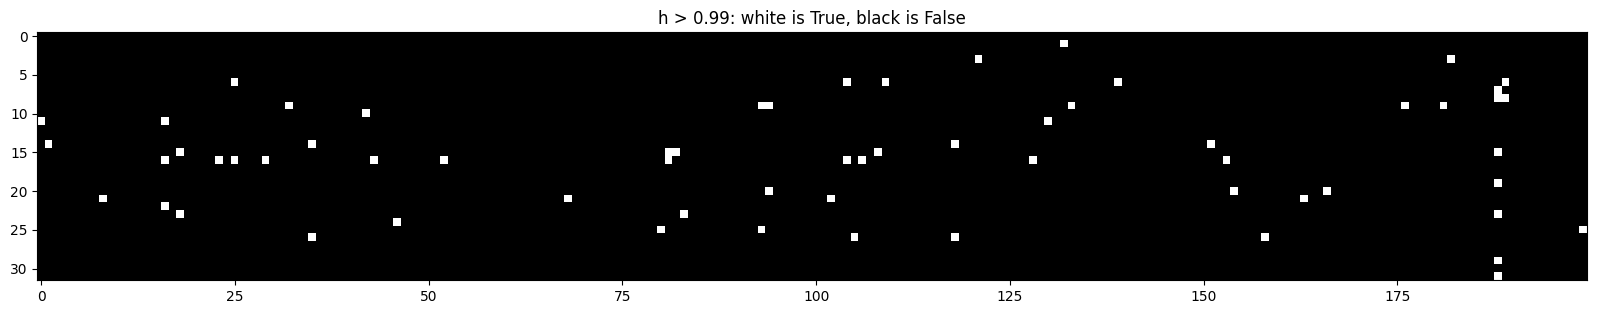

In [15]:
plt.figure(figsize = (20, 10))
plt.imshow(h.abs() > 0.99, cmap = "gray", interpolation='nearest')
plt.title("h > 0.99: white is True, black is False");

##### Kaimin initialization

The paper where it first appeared: https://arxiv.org/abs/1502.01852

How pytorch uses it: https://pytorch.org/docs/stable/nn.init.html

in essence explains where numbers (0.01, 0.1, 0.2) come from in initializing the weights and biases?

x mean = 0.014, std = 0.994
y mean = -0.004, std = 3.047
y scaled mean = -0.001, std = 0.964


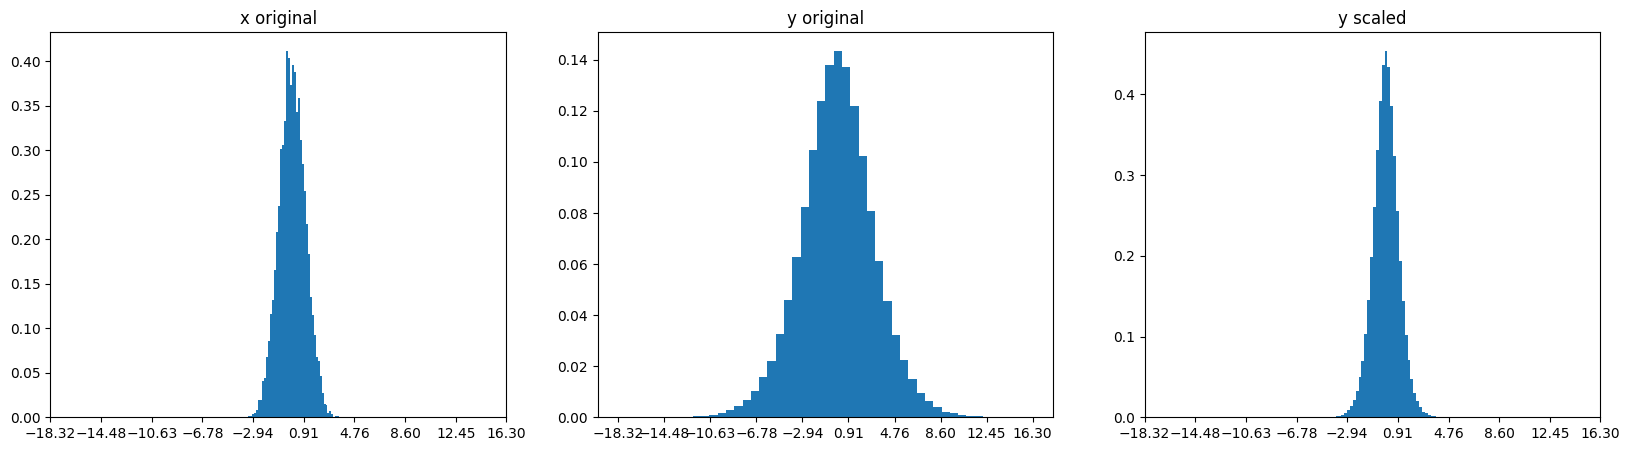

In [16]:
# 1000 training examples, 10 features
x = torch.randn(1000,10)

# 10 features, 200 neurons
w = torch.randn(10, 200)

# pre-activation
y = x @ w

print(f"x mean = {x.mean():.3f}, std = {x.std():.3f}")
print(f"y mean = {y.mean():.3f}, std = {y.std():.3f}")

fig, axes = plt.subplots(1, 3, figsize = (20, 5))

axes[0].hist(x.flatten().data, bins = 50, density = True)
axes[0].set_xticks(torch.linspace(y.min(), y.max(), 10))
axes[0].set_title("x original")


axes[1].hist(y.flatten().data, bins = 50, density = True)
axes[1].set_xticks(torch.linspace(y.min(), y.max(), 10))
axes[1].set_title("y original");

# scale the weights by Kaiming Initialization: dividing by sqrt(fan_in) = sqrt(10) in this case
w_scaled = w /  math.sqrt(w.shape[0])
y_scaled = x @ w_scaled

axes[2].hist(y_scaled.flatten().data, bins = 50, density = True)
axes[2].set_xticks(torch.linspace(y.min(), y.max(), 10))
axes[2].set_title("y scaled");

print(f"y scaled mean = {y_scaled.mean():.3f}, std = {y_scaled.std():.3f}")

##### Batch Normalization

in essence, we don't want pre-activation states too small because tanh won't be doing anything and we don't want them too large because then tanh is too saturated. we want them to have a roughly gaussian distribution, at least at inialization. 

so if we want a roughly gaussian distribution, std = 1. we can simply normalize the hidden states to have that gaussian property. 

In [17]:
n_embd = 10 
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),generator=g) * 0.2
b1 = torch.randn(n_hidden,generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),generator=g) * 0.01 # Initialize to small values
b2 = torch.randn(vocab_size,generator=g) * 0 # Remove bias

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))


parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

12297


In [18]:
ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)

# batch 
Xb, Yb = Xtr[ix], Ytr[ix]

# forward pass
emb = C[Xb] # embed characters into vector space
embcat = emb.view((emb.shape[0], -1)) # flatten

hpreact = embcat @ W1 + b1 # hidden layer pre-activation

# normalize the batch ➡️ unit gaussian
hpreact = (hpreact - hpreact.mean(dim=0, keepdim=True)) / (hpreact.std(dim=0, keepdim=True) + 1e-6)

# we want it to be gaussian only at initialization (not always), the Neural Network may need to change the it
# Scale and Shift: scale the normalized batch by a learnable parameter (gamma) and shift it by another learnable parameter (beta)
hpreact = hpreact * bngain + bnbias

h = torch.tanh(hpreact) # hidden layer activation
logits = h @ W2 + b2 # output layer 
loss = F.cross_entropy(logits, Yb) # cross-entropy loss

print(f"initial loss = {loss}")

initial loss = 3.3146886825561523


sampling

In [19]:
# Calibrate the batch norm statistics
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view((emb.shape[0], -1))
    hpreact = embcat @ W1 + b1

    bnmean = hpreact.mean(dim=0, keepdim=True)
    bnstd = hpreact.std(dim=0, keepdim=True)

In [20]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "dev": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]

    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view((emb.shape[0], -1)) # (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 # (N, n_hidden)
    
    # batch norm in test mode
    hpreact = (hpreact - bnmean) / (bnstd + 1e-6)
    hpreact = hpreact * bngain + bnbias


    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)

    print(f"{split} loss: {loss.item()}")

split_loss("train")
split_loss("dev")

train loss: 3.3056492805480957
dev loss: 3.305365800857544


so finally we have

In [21]:
n_embd = 10 
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),generator=g) * 0.2
b1 = torch.randn(n_hidden,generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),generator=g) * 0.01 # Initialize to small values
b2 = torch.randn(vocab_size,generator=g) * 0 # Remove bias

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

# mean and std buffers, (not trainable)
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True
  
ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)

# batch 
Xb, Yb = Xtr[ix], Ytr[ix]

# forward pass
emb = C[Xb] # embed characters into vector space
embcat = emb.view((emb.shape[0], -1)) # flatten

hpreact = embcat @ W1 + b1 # hidden layer pre-activation

# normalize the batch ➡️ unit gaussian
bnmeani = hpreact.mean(dim=0, keepdim=True)
bnstdi = hpreact.std(dim=0, keepdim=True)

hpreact = (hpreact - bnmeani) / (bnstdi + 1e-6)

# updating outside (and on the side) of the gradient based optimization
with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

# we want it to be gaussian only at initialization (not always), the Neural Network may need to change the it
# Scale and Shift: scale the normalized batch by a learnable parameter (gamma) and shift it by another learnable parameter (beta)
hpreact = hpreact * bngain + bnbias

h = torch.tanh(hpreact) # hidden layer activation
logits = h @ W2 + b2 # output layer 
loss = F.cross_entropy(logits, Yb) # cross-entropy loss

print(f"initial loss = {loss}")

@torch.no_grad()
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "dev": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]

    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view((emb.shape[0], -1)) # (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 # (N, n_hidden)
    
    # batch norm in test mode
    hpreact = (hpreact - bnmean_running) / (bnstd_running + 1e-6)
    hpreact = hpreact * bngain + bnbias


    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)

    print(f"{split} loss: {loss.item()}")

split_loss("train")
split_loss("dev")

12297
initial loss = 3.3146886825561523
train loss: 3.3057639598846436
dev loss: 3.3057150840759277


##### Cleaning it up 

In [23]:
# visualization parameters (you may play with these)
gain = 0.2
last_layer_confidence = 0.1

using_batch_norm = True
div_by_fan_in = True

In [24]:
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out), generator = g)
        if div_by_fan_in:
            self.weight /= fan_in ** 0.5
        self.bias = torch.zeros((fan_out)) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained while running `momentum update`)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            # batch mean
            xmean = x.mean(0, keepdim= True)
            # batch variance
            xvar = x.var(0, keepdim= True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # update the buffers in training
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd),       generator = g)

if not using_batch_norm:
    layers = [
        Linear(n_embd * block_size, n_hidden), Tanh(),
        Linear(         n_hidden, n_hidden), Tanh(),
        Linear(         n_hidden, n_hidden), Tanh(),
        Linear(         n_hidden, n_hidden), Tanh(),
        Linear(         n_hidden, n_hidden), Tanh(),
        Linear(         n_hidden, vocab_size)
    ]
if using_batch_norm:
    layers = [
    Linear(n_embd * block_size, n_hidden, bias = False), BatchNorm1d(n_hidden) ,Tanh(),
    Linear(         n_hidden, n_hidden, bias = False), BatchNorm1d(n_hidden) ,Tanh(),
    Linear(         n_hidden, n_hidden, bias = False), BatchNorm1d(n_hidden) ,Tanh(),
    Linear(         n_hidden, n_hidden, bias = False), BatchNorm1d(n_hidden) ,Tanh(),
    Linear(         n_hidden, n_hidden, bias = False), BatchNorm1d(n_hidden) ,Tanh(),
    Linear(         n_hidden, vocab_size, bias = False), BatchNorm1d(vocab_size) # you can add it here too
    ]



with torch.no_grad():
    # last layer: make less confident
    if not using_batch_norm:
        layers[-1].weight *= last_layer_confidence
    if using_batch_norm:
        layers[-1].gamma *= last_layer_confidence
    
    # other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            # change this gain (default 5/3)
            layer.weight *= gain

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

47024


In [25]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
update_to_data_ratio = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # embed characters into vector space
    x = emb.view((emb.shape[0], -1)) # flatten
    for layer in layers:
        x = layer(x)
    # compute loss
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f"step {i} loss {loss.item()}")

    lossi.append(loss.item())

    # update to data ratio: How great is the update compared to the data itself?
    with torch.no_grad():
        update_to_data_ratio.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters if p.grad is not None])

    if i >= 1000:
        break

step 0 loss 3.287036418914795


##### Visualizations

Detailed Layer Numbering:
Layer 0: Linear(n_embd * block_size, n_hidden, bias=False)

Layer 1: BatchNorm1d(n_hidden)

Layer 2: Tanh()

Layer 3: Linear(n_hidden, n_hidden, bias=False)

Layer 4: BatchNorm1d(n_hidden)

Layer 5: Tanh()

Layer 6: Linear(n_hidden, n_hidden, bias=False)

Layer 7: BatchNorm1d(n_hidden)

Layer 8: Tanh()

Layer 9: Linear(n_hidden, n_hidden, bias=False)

Layer 10: BatchNorm1d(n_hidden)

Layer 11: Tanh()

Layer 12: Linear(n_hidden, n_hidden, bias=False)

Layer 13: BatchNorm1d(n_hidden)

Layer 14: Tanh()

Layer 15: Linear(n_hidden, vocab_size, bias=False)

Layer 16: BatchNorm1d(vocab_size)

forward pass activation stats

layer 2 mean -0.00 std 0.64 saturated 2.56%
layer 5 mean 0.00 std 0.66 saturated 2.00%
layer 8 mean 0.00 std 0.66 saturated 1.47%
layer 11 mean 0.00 std 0.66 saturated 1.22%
layer 14 mean -0.00 std 0.66 saturated 0.72%


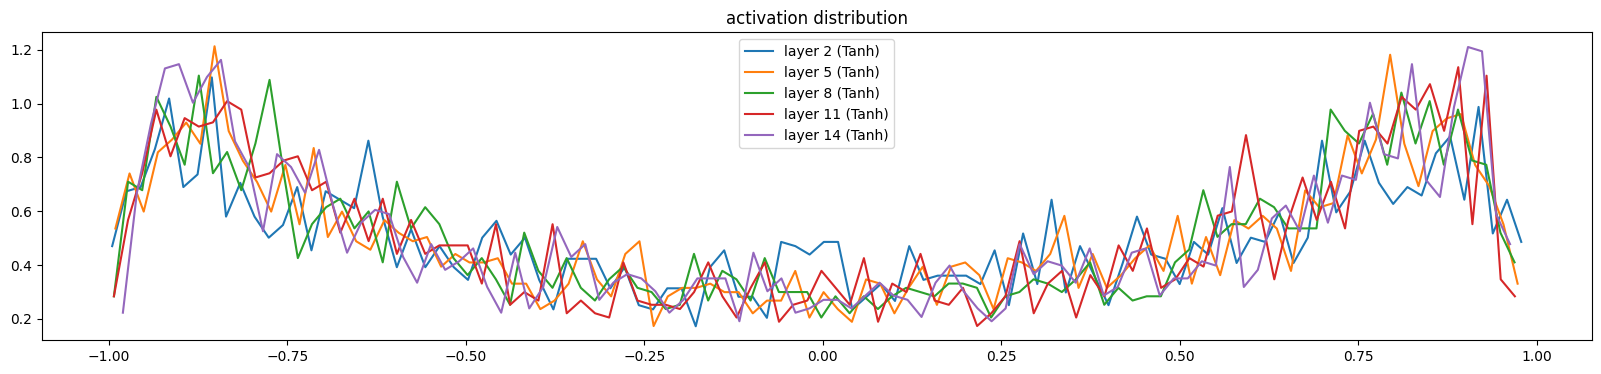

In [27]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f"layer {i} mean {t.mean().item():.2f} std {t.std().item():.2f} saturated {((t.abs() > 0.97).float().mean().item()) * 100:.2f}%")

        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())

        legends.append(f"layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title("activation distribution")
plt.show()

Backward pass Gradient Statistics

layer 2 mean 0.00000 std 0.00125 saturated 0.00000000%
layer 5 mean -0.00000 std 0.00110 saturated 0.00000000%
layer 8 mean -0.00000 std 0.00095 saturated 0.00000000%
layer 11 mean 0.00000 std 0.00094 saturated 0.00000000%
layer 14 mean 0.00000 std 0.00105 saturated 0.00000000%


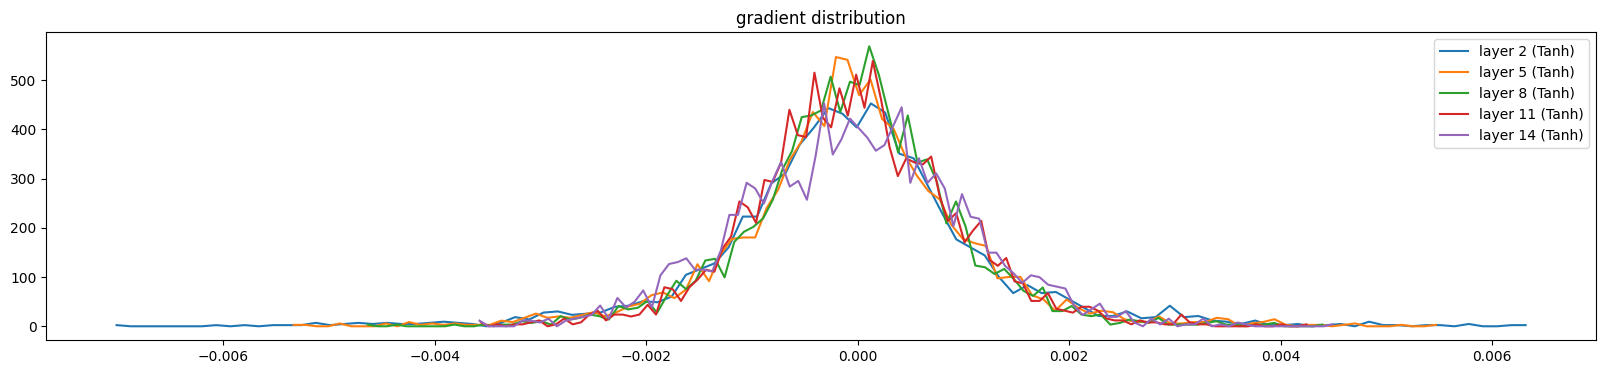

In [28]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f"layer {i} mean {t.mean().item():.5f} std {t.std().item():.5f} saturated {((t.abs() > 0.97).float().mean().item()) * 100:.8f}%")

        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())

        legends.append(f"layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title("gradient distribution")
plt.show()

Parameter Activation and Gradient Statistics

weight shape (27, 10) | mean 0.00000 | std 0.00737 | grad:data ratio 7.37e-03
weight shape (30, 100) | mean 0.00031 | std 0.01392 | grad:data ratio 2.29e-01
weight shape (100, 100) | mean 0.00003 | std 0.00601 | grad:data ratio 2.01e-01
weight shape (100, 100) | mean -0.00002 | std 0.00522 | grad:data ratio 1.91e-01
weight shape (100, 100) | mean -0.00005 | std 0.00506 | grad:data ratio 1.92e-01
weight shape (100, 100) | mean -0.00011 | std 0.00522 | grad:data ratio 2.00e-01
weight shape (100, 27) | mean 0.00002 | std 0.01235 | grad:data ratio 2.86e-01


Text(0.5, 1.0, 'Weights Gradient distribution')

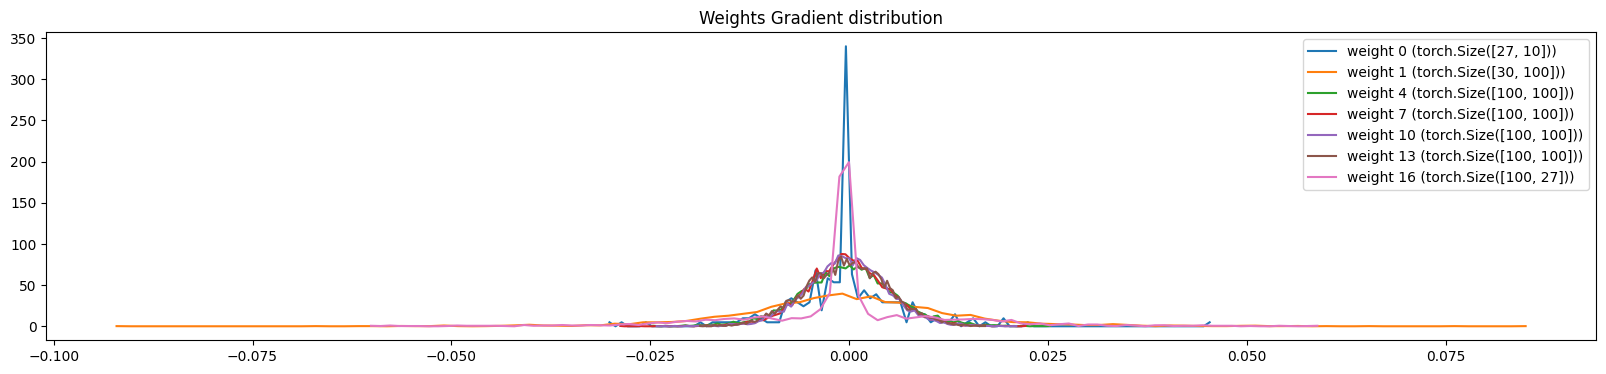

In [29]:
plt.figure(figsize=(20, 4))
legends = []

for i,p in enumerate(parameters):
    t = p.grad
    # neglect bias and batch norm parameters (weights only)
    if p.ndim == 2:
        print(f"weight shape {tuple(p.shape)} | mean {t.mean().item():.5f} | std {t.std().item():.5f} | grad:data ratio {t.std() / p.std():.2e}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"weight {i} ({p.shape})")

plt.legend(legends)
plt.title("Weights Gradient distribution")

data ratio over time

Text(0.5, 1.0, 'Update to Data ratio')

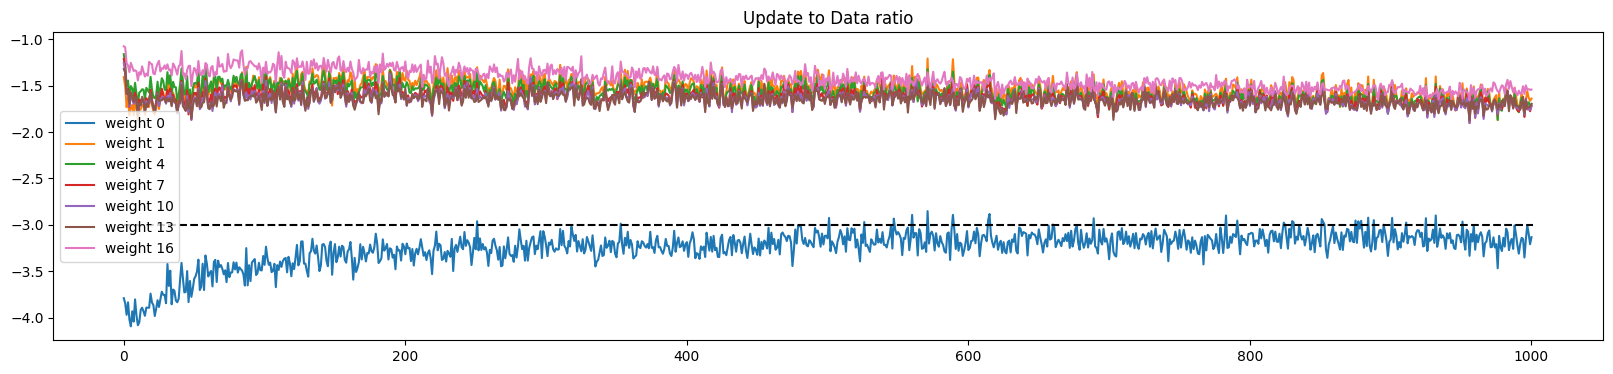

In [30]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p
    # neglect bias and batch norm parameters (weights only)
    if p.ndim == 2:
        plt.plot([update_to_data_ratio[j][i] for j in range(len(update_to_data_ratio))])
        legends.append(f"weight {i}")
    
# rough guide for what it should be: 1e-3
plt.plot([0, len(update_to_data_ratio)], [-3, -3], color="black", linestyle="--")
plt.legend(legends)
plt.title("Update to Data ratio")